# Hit rates

Reloads the hit rate and hit count data from `Burglary data.ipynb` and analyses in some different ways.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import scipy.stats
import lzma, pickle
import pandas as pd

In [2]:
with lzma.open("case_study_hit_rates.pic.xz", "rb") as f:
    hitrates = pickle.load(f)

# Autocorrelation

If $x_i$ is the _difference_ between hit rates at stage $i$, then look at $(x_{i+1} - x_i)$.

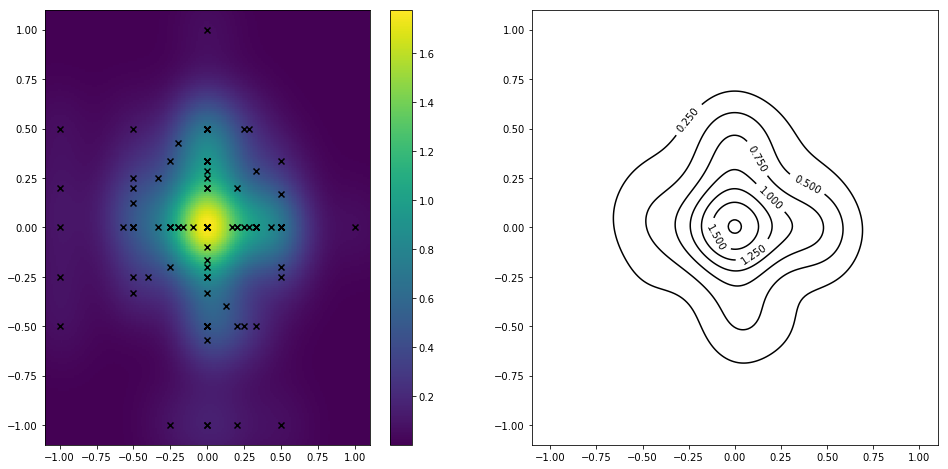

In [3]:
coverage = 10
series = [v[0][coverage] - v[1][coverage] for k,v in hitrates.items()]
pts = np.asarray([series[:-1], series[1:]])
#pts = np.asarray([[x,0.2+y*0.1] for x,y in np.random.random((100,2))]).T

fig, axes = plt.subplots(ncols=2, figsize=(16,8))

kernel = scipy.stats.kde.gaussian_kde(pts)
x = np.linspace(-1.1, 1.1, 200)
y = np.linspace(-1.1, 1.1, 200)
xx, yy = np.meshgrid(x, y)
matrix = kernel([xx.flatten(), yy.flatten()]).reshape(xx.shape)

ax = axes[0]
mappable = ax.pcolor(x, y, matrix)
plt.colorbar(mappable, ax=ax)
ax.scatter(*pts, marker="x", color="black")

ax = axes[1]
CS = ax.contour(x, y, matrix, colors="black")
plt.clabel(CS, inline=1, fontsize=10)
None

In [4]:
scipy.stats.wilcoxon(series)

WilcoxonResult(statistic=918.0, pvalue=0.84261213340113672)

Some standard tests for correlation.  No evidence really.

In [5]:
scipy.stats.spearmanr(*pts)

SpearmanrResult(correlation=-0.068135962583510706, pvalue=0.47332722066734012)

In [6]:
ptsr = np.random.random(pts.shape)
scipy.stats.spearmanr(*ptsr)

SpearmanrResult(correlation=0.043058420387251321, pvalue=0.65066524980997276)

In [7]:
scipy.stats.pearsonr(*pts)

(-0.057014048798167662, 0.5486280645243975)

The same, but with randomly generated (definitely not correlated!) data.

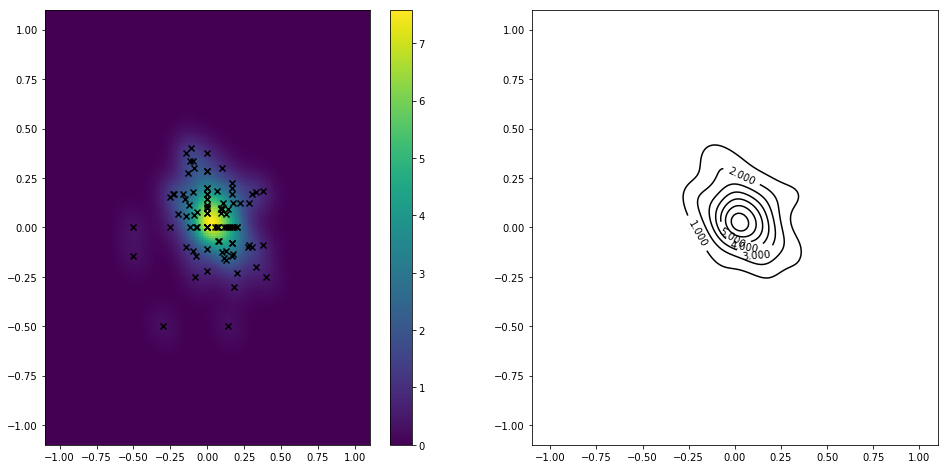

In [8]:
def random_gen(proba, probb, size, per_trial_size=10):
    out = []
    for _ in range(size):
        n = np.random.poisson(per_trial_size)
        a = np.random.binomial(n, proba)
        b = np.random.binomial(n, probb)
        out.append(a/n - b/n)
    return np.asarray(out)
    
series = random_gen(0.2, 0.2, 110)
pts = np.asarray([series[:-1], series[1:]])

fig, axes = plt.subplots(ncols=2, figsize=(16,8))

kernel = scipy.stats.kde.gaussian_kde(pts)
x = np.linspace(-1.1, 1.1, 200)
y = np.linspace(-1.1, 1.1, 200)
xx, yy = np.meshgrid(x, y)
matrix = kernel([xx.flatten(), yy.flatten()]).reshape(xx.shape)

ax = axes[0]
mappable = ax.pcolor(x, y, matrix)
plt.colorbar(mappable, ax=ax)
ax.scatter(*pts, marker="x", color="black")

ax = axes[1]
CS = ax.contour(x, y, matrix, colors="black")
plt.clabel(CS, inline=1, fontsize=10)
None

# Bayesian idea

Model is that for each observation, conditioned on $n$ the number of events, the predictions method will detect $\operatorname{Bin}(n,p)$ of the events, where $p$ is fixed but depends on the prediction model.

If we use a conjugate prior, the Beta distribution, then this takes on a [very simple form](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions).

In [9]:
with lzma.open("case_study_hit_counts.pic.xz", "rb") as f:
    hitcounts = pickle.load(f)

In [10]:
coverage = 10
a = [v[0][coverage] for k,v in hitcounts.items()]
b = [v[1][coverage] for k,v in hitcounts.items()]

In [11]:
def posterior(data):
    alpha = sum(p[0] for p in data)
    beta = sum(p[1] for p in data) - alpha
    alpha += 1
    beta += 1
    return scipy.stats.beta(alpha, beta), alpha, beta

0.012853470437


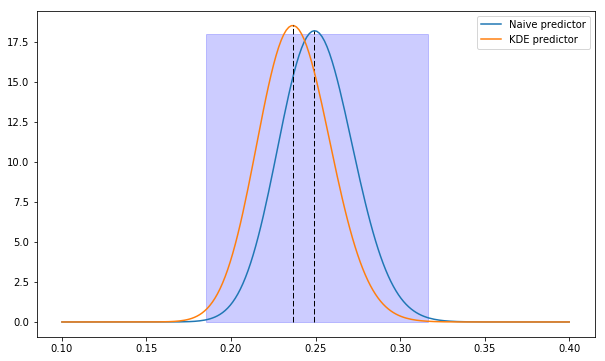

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(0.1, 0.4, 200)

f, alpha, beta = posterior(a)
ax.plot(x, f.pdf(x), label="Naive predictor")
mode = (alpha - 1) / (alpha + beta - 2)
ax.plot([mode, mode], [0,f.pdf(mode)], linestyle="--", linewidth=1, color="black")
mean = alpha / (alpha + beta)
var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
sd = np.sqrt(var)
r = matplotlib.patches.Rectangle((mean - 3 * sd,0), 6 * sd, 18, color="blue", alpha=0.2)
ax.add_patch(r)

f, alpha, beta = posterior(b)
ax.plot(x, f.pdf(x), label="KDE predictor")
mode1 = (alpha - 1) / (alpha + beta - 2)
ax.plot([mode1, mode1], [0,f.pdf(mode1)], linestyle="--", linewidth=1, color="black")
print(mode - mode1)

ax.legend()
None

So the above suggests that the ``naive'' predictor does better than the KDE method.

It's worth thinking about what this tells us.  Under our model, given the data, we have plotted the posterior distribution for the value of $p$.  A larger $p$ is a ``better'' prediction.

For example, we can calculate the probability that $p_n = p_{\text{naive}}$ is greater than $p_k = p_{\text{kde}}$ as
$$ \int_{p_n > p_k} \mathbb P(p_n, p_k) \ dp_n \ dp_k
= \int_0^1 dp_k \ \int_{p_k}^1 dp_n \ \mathbb P(p_n, p_k). $$
The numerical calculation below gives this as around 72%.

In [13]:
f_naive, alpha, beta = posterior(a)
f_kde, alpha, beta = posterior(b)

def func(t):
    v, _ = scipy.integrate.quad(f_naive.pdf, t, 1)
    return f_kde.pdf(t) * v
scipy.integrate.quad(func, 0, 1)

(0.6616552212458945, 1.4395905688539712e-08)

Why is it that the naive predictor seems to do better here, while a visualisation shows the KDE method being better?

- Because we only looked at 10% coverage!

In [14]:
def fit_bin(coverage):
    a = [v[0][coverage] for k,v in hitcounts.items()]
    b = [v[1][coverage] for k,v in hitcounts.items()]
    
    f_naive, alpha, beta = posterior(a)
    mean_naive = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    sd_naive = np.sqrt(var)
    f_kde, alpha, beta = posterior(b)
    mean_kde = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    sd_kde = np.sqrt(var)
    def func(t):
        v, _ = scipy.integrate.quad(f_naive.pdf, t, 1)
        return f_kde.pdf(t) * v
    prob, _ = scipy.integrate.quad(func, 0, 1)
    
    series = [a/b - c/d for ((a,b), (c,d)) in zip(a, b)]
    wx = scipy.stats.wilcoxon(series)
    
    return prob, mean_naive, sd_naive, mean_kde, sd_kde, wx.pvalue

In [15]:
k = list(hitcounts)[0]
x = list(hitcounts[k][0])
data = [fit_bin(t) for t in x]

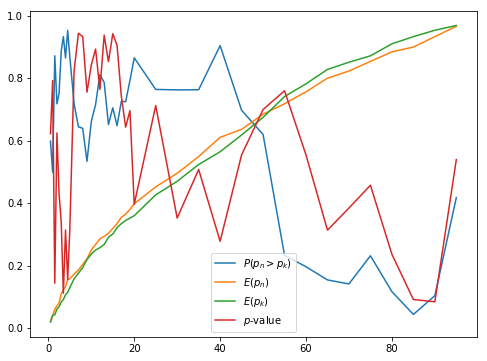

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, [row[0] for row in data], label="$P(p_n > p_k)$")
ax.plot(x, [row[1] for row in data], label="$E(p_n)$")
ax.plot(x, [row[3] for row in data], label="$E(p_k)$")
ax.plot(x, [row[5] for row in data], label="$p$-value")
ax.legend()

This is maybe not so interesting, in that it doesn't give an effect size: if $p_n$ and $p_k$ are very tightly distributed, then we can have $\mathbb P(p_n > p_k)$ large while the absolute difference between $p_n, p_k$ is small.

In [17]:
f = scipy.stats.beta(5, 6)
f.ppf(0.25), f.ppf(0.5), f.ppf(0.75)

(0.35068081415624408, 0.4516941562236631, 0.55549323919966298)

In [18]:
def find_distributions(coverage):
    a = [v[0][coverage] for k,v in hitcounts.items()]
    b = [v[1][coverage] for k,v in hitcounts.items()]
    
    f_naive, alpha, beta = posterior(a)
    f_kde, alpha, beta = posterior(b)

    return f_naive, f_kde

In [19]:
k = list(hitcounts)[0]
x = list(hitcounts[k][0])
dists = [find_distributions(t) for t in x]

In [20]:
pvalues = [row[5] for row in data]

def fill_pvalues(ax, coverages, cutoff=0.05):
    stop_starts = []
    for i, p in enumerate(pvalues):
        if i == 0:
            xmin = 0
        else:
            xmin = (coverages[i-1] + coverages[i]) / 2
        if i == len(pvalues) - 1:
            xmax = 100
        else:
            xmax = (coverages[i+1] + coverages[i]) / 2
        if p <= cutoff:
            stop_starts.append((xmin, xmax))
    index = 0
    while index < len(stop_starts) - 1:
        if stop_starts[index][1] == stop_starts[index + 1][0]:
            stop_starts[index] = (stop_starts[index][0], stop_starts[index+1][1])
            del stop_starts[index + 1]
        else:
            index += 1
    for xmin, xmax in stop_starts:
        rp = matplotlib.patches.Rectangle((xmin,0), xmax-xmin, 1, facecolor="#999999", alpha=0.5, edgecolor="none")
        ax.add_patch(rp)

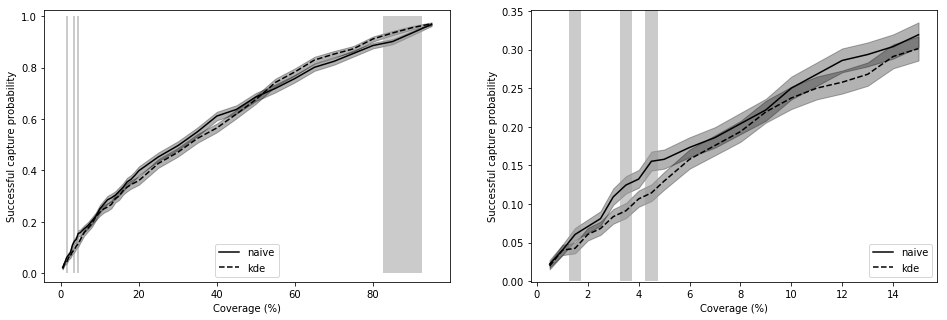

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

def plot(ax, slic):
    color = "black"
    y = [fn.ppf(0.5) for fn, fk in dists[slic]]
    ax.plot(x[slic], y, color=color, label="naive")
    y1 = [fn.ppf(0.25) for fn, fk in dists[slic]]
    y2 = [fn.ppf(0.75) for fn, fk in dists[slic]]
    ax.fill_between(x[slic], y1, y2, alpha=0.3, color=color, linewidth=1)

    y = [fk.ppf(0.5) for fn, fk in dists[slic]]
    ax.plot(x[slic], y, color=color, linestyle="--", label="kde")
    y1 = [fk.ppf(0.25) for fn, fk in dists[slic]]
    y2 = [fk.ppf(0.75) for fn, fk in dists[slic]]
    ax.fill_between(x[slic], y1, y2, alpha=0.3, color=color, linewidth=1)
    
    fill_pvalues(ax, x, 0.2)
    ax.legend()
    ax.set(xlabel="Coverage (%)", ylabel="Successful capture probability")

plot(axes[0], slice(0,len(dists)))
plot(axes[1], slice(0,20))

In [22]:
fig.savefig("fit_bin.pdf")

## Graphics for talk

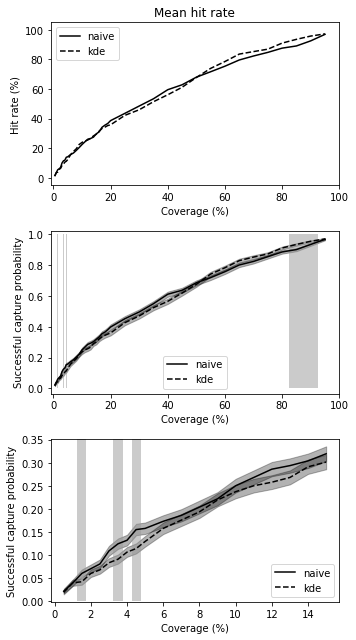

In [23]:
fig, axes = plt.subplots(nrows=3, figsize=(5,9))
data = hitrates

frame = pd.DataFrame({k : v[0] for k, v in data.items()}).T.describe().T
ax = axes[0]
ax.plot(frame["mean"]*100, color="black", linestyle="-", label="naive")
frame = pd.DataFrame({k : v[1] for k, v in data.items()}).T.describe().T
ax.plot(frame["mean"]*100, color="black", linestyle="--", label="kde")
ax.legend()
ax.set(xlabel="Coverage (%)", ylabel="Hit rate (%)")
ax.set(xlim=[-5,105], ylim=[-5,105])
ax.set_title("Mean hit rate")

plot(axes[1], slice(0,len(dists)))
for ax in axes[:2]:
    ax.set(xlim=[-1,100])
plot(axes[2], slice(0,20))

fig.tight_layout()
fig.savefig("talk_hit_rates.pdf")